## Plot results

The purpose of this notebook is to visualize models' performances singlehandedly and/or with respect to each other's. It expects the selected models to have already gone through training using the `run_exp_script.py` script.

#### Set up

In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import glob
import pandas as pd
import seaborn as sns
import geopandas as gpd
from matplotlib import pyplot as plt
from utils import plot_utils as plot
from models.build_models import build_model
from datasets.dataset_classes import MSDataset, NLDataset, MSNLDataset
from testing import test
import torch
from sklearn.metrics import r2_score

# Paths and Files
CKPT_PATH = 'models/checkpoints/'
DATASET   = 'data/dataset_2013+.csv'
DATA_DIR  = 'data/landsat_7_less/'
FOLDS     = 'data/dhs_incountry_folds_2013+.pkl'
bg_map = gpd.read_file('data/africa.json')

In [2]:
test_name = 'msnlt_conf_t13'

#### Display curves per model

C:\Users\Isabelle\anaconda3\envs\mpa\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Isabelle\anaconda3\envs\mpa\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Isabelle\anaconda3\envs\mpa\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Isabelle\anaconda3\envs\mpa\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

[]

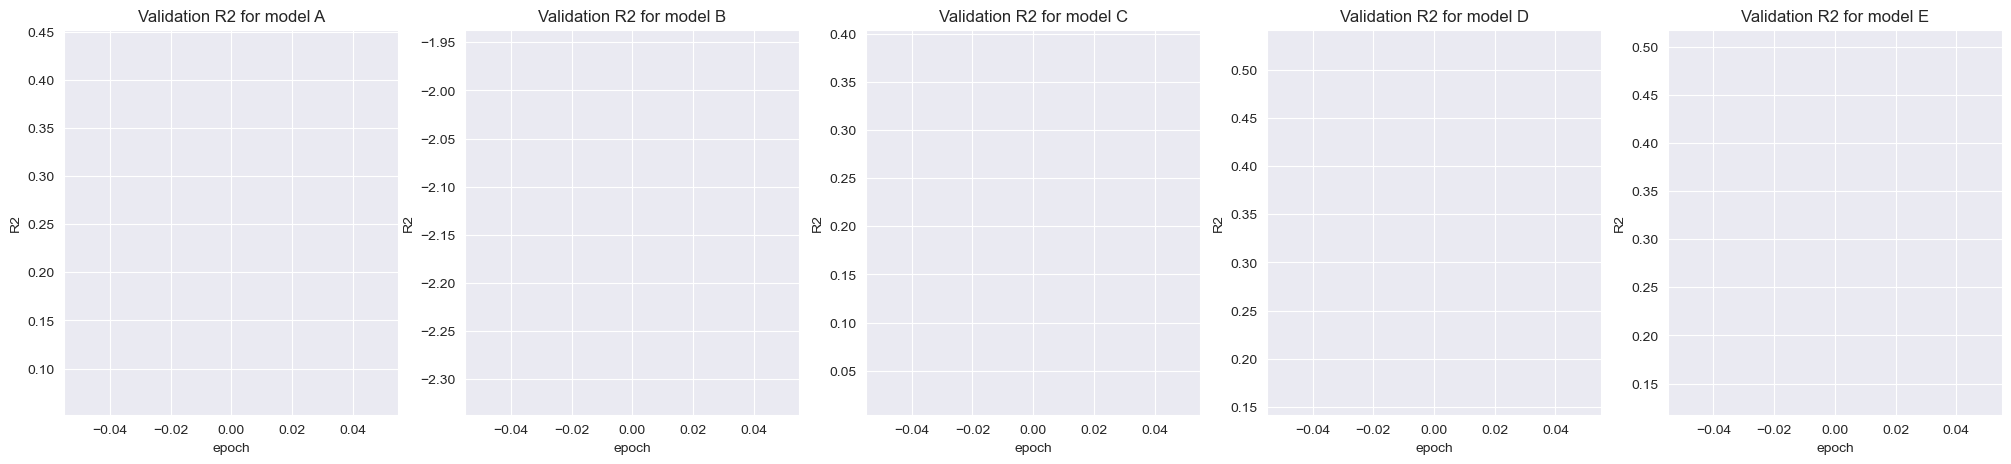

In [3]:
RESULT_PATH = 'models/results/conf_t/' + test_name + '.pkl'
result_list = glob.glob(RESULT_PATH)

# Load Results
results = dict()
for i in range(len(result_list)):
    with open(result_list[i], 'rb') as f:
        results[i] = pickle.load(f)
result_list

# Validation R2 per epoch

multi_val_dict, val_dataframes = dict(), dict()
for i in results:
    multi_val_dict[i] = plot.extract_crossval_results(results=results[i], var='test_r2', new_var="R2", to_cpu=False)
    val_dataframes[i] = pd.DataFrame.from_dict(multi_val_dict[i])

# Plot preparation
sns.set_palette('pastel')
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

for fold in ['A', 'B', 'C', 'D', 'E']:
    x = ord(fold) - ord('A')
    ax[x].set_title(f'Validation R2 for model {fold}')
    for i in results:
        # Calculate the y-axis limits based on your data range
        min_y = val_dataframes[i][val_dataframes[i].fold == fold]["R2"].min()-0.2
        max_y = val_dataframes[i][val_dataframes[i].fold == fold]["R2"].max()+0.2
        
        sns.lineplot(ax=ax[x], data=val_dataframes[i][val_dataframes[i].fold == fold], x="epoch", y="R2", legend=True).set(ylim=(min_y, max_y))
plt.plot()


C:\Users\Isabelle\anaconda3\envs\mpa\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Isabelle\anaconda3\envs\mpa\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Isabelle\anaconda3\envs\mpa\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Isabelle\anaconda3\envs\mpa\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

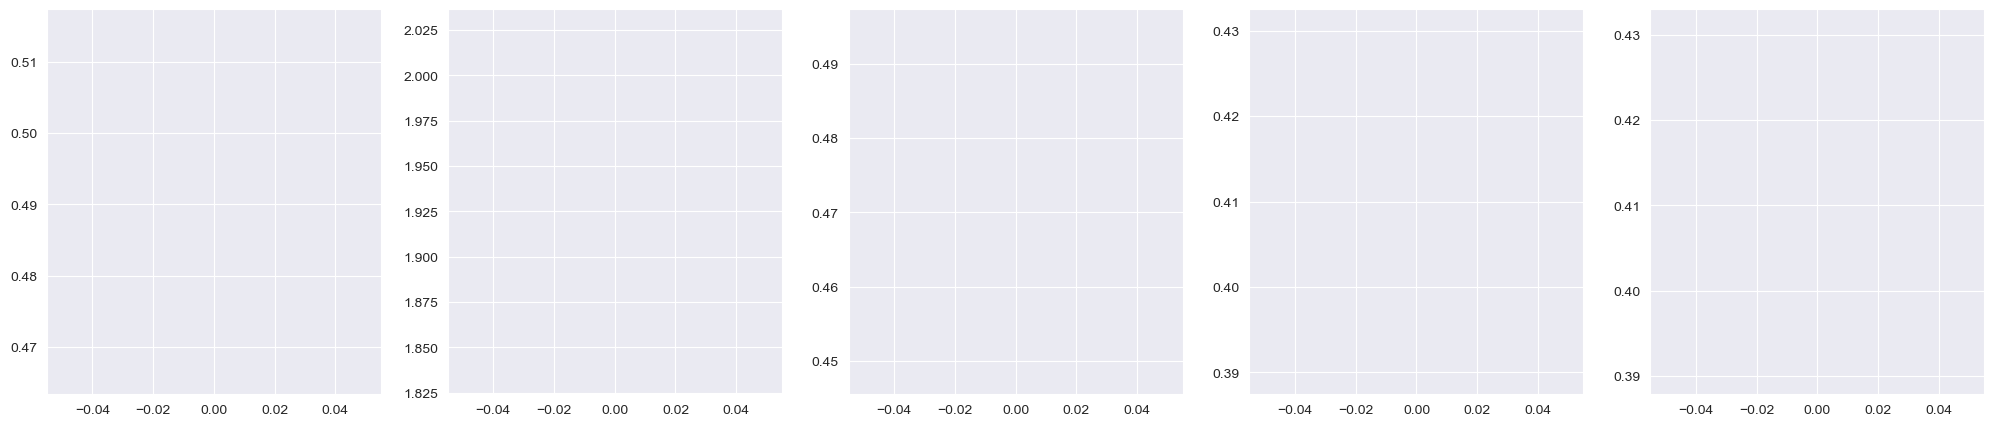

In [4]:
# Test Loss per epoch

fig, ax = plt.subplots(1, 5, figsize=(25, 5))
i=0
for f in 'ABCDE':
    sns.lineplot(results[0][f]['test_loss'],ax = ax[i])
    i += 1


#### Create dataset with predictions on test sets

In [5]:
# Parameters
save_path='results/conf_t/' + test_name + '.csv' 
#save_path='results/conf_t/msnlt_conf_comb1.csv' 
model_config_filename = 'configs/msnlt_gs_t13.json' # modify to corresponding configuration file
data_config_filename = 'data/dhs_incountry_folds_2013+.pkl'

# Test function
df_test = test.main(
    write_path=save_path,
    fold_path=FOLDS,
    network_config_filename=model_config_filename,
    #data_config_filename=data_config_filename,
    dataset=pd.read_csv(DATASET),
    model_type="msnlt" # modify to corresponding model type
)


C:\Users\Isabelle\anaconda3\envs\mpa\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


#### Compute R2

In [6]:
# Compute R2

# CSV to df
save_path = save_path='results/conf_t/' + test_name + '.csv' 
df_test = pd.read_csv(save_path)
df_test = df_test.rename(columns={"wealthpooled": "True Wealth", "predicted_wealth": "Predicted Wealth"})

# Compute R2
df_test= df_test[~df_test['Predicted Wealth'].isna()]
r2_all = r2_score(df_test['True Wealth'], df_test['Predicted Wealth'])
print(f'r2_all = {r2_all}')

r2_all = -134.66469348780691


#### Figures

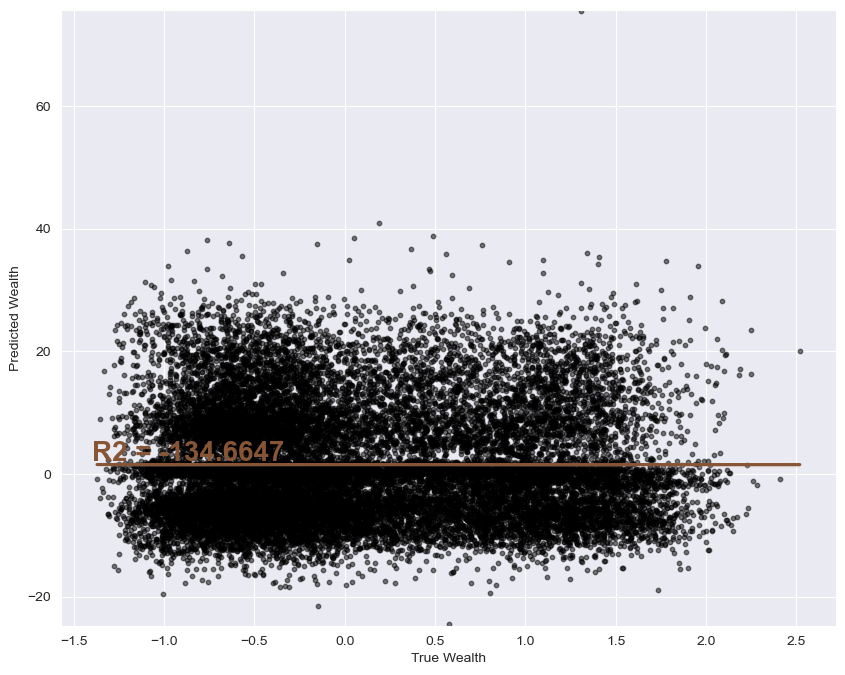

In [7]:
pal = sns.color_palette("copper")
sns.set_style("darkgrid", {'axes.grid' : True})

plt.figure(figsize=(10, 8))
sns.regplot(x="True Wealth", y="Predicted Wealth", data=df_test, x_ci='sd', marker='o', scatter_kws={'alpha': 0.5, 'color': 'black', 's': 10}, line_kws={'color': pal.as_hex()[2]})

# Set the x and y axis limits to ensure all points are displayed
plt.xlim(df_test["True Wealth"].min() - 0.2, df_test["True Wealth"].max() + 0.2)
plt.ylim(df_test["Predicted Wealth"].min() - 0.2, df_test["Predicted Wealth"].max() + 0.2)

plt.text(-1.4, 2.2, 'R2 = ' + str(round(r2_all, 4)), fontsize='20', weight='bold', color=pal.as_hex()[2])
plt.show()


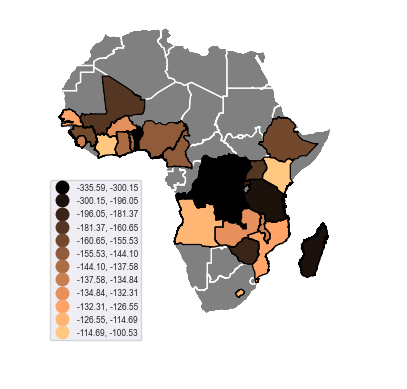

<Figure size 800x1000 with 0 Axes>

In [8]:
plot.country_plot(
    bg_map=bg_map,
    data=df_test,
    cmap='copper',
    bg_color='gray',
    edgecolor='white'
)

sample size: 11874
r2 urban = -86.38704740021502
r2 rural = -178.85974974023125


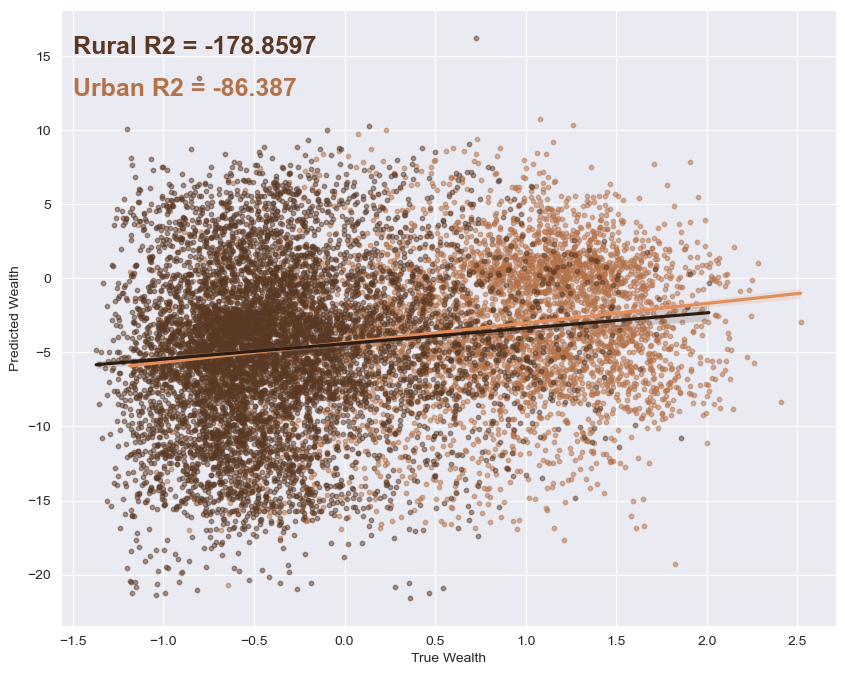

In [9]:
df_test_ur = df_test[df_test['urban_rural']!=-1]
print('sample size:', len(df_test_ur))
df_test_ur = df_test_ur.rename({'urban_rural':'Urban vs Rural'},axis=1)

plot.split_regplot(
    data=df_test_ur,
    col_to_split='Urban vs Rural',
    newcol_name='Urban vs Rural',
    split_val=1.,
    labelinf='Rural',
    labelsup='Urban',
    pal=sns.color_palette("copper"),
    #scatter_kws={'alpha':0.2, 's':10},
    #line_kws= {'alpha':1., 'linewidth':2}
    )

